tgb - 6/1/2020 - Check the timescale separation between "slow forcing" from the potential and "fast evolution" of the moist margin

# Initialization

In [1]:
!rm util # Run if util folder already exists, will produce an error otherwise

rm: cannot remove ‘util’: No such file or directory


In [2]:
!ln -s ../../util util # Symlink to utilities folder

## Imports

In [3]:
# Initial imports
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [4]:
# Figure characteristics common to all Figures
fz = 15
lw = 3
siz = 10

plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

# Physical constants
stday = 24*3600

In [5]:
col1 = np.array([255,126,14])/255
col2 = np.array([43,160,43])/255
col3 = np.array([31,119,179])/255

col_A = ['C0', 'C1', 'C2']

## Utilities

In [6]:
class Bunch(object):
  
    def __init__(self, adict):
        self.__dict__.update(adict)

In [7]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [8]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [9]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind

# Load reduced data to estimate timescales

In [10]:
pathPKL = '../../dev/tbeucler/PKL_DATA/'

In [11]:
# Load reduced data into dictionary S
path = pathPKL+'2020_01_08_COSMO_LFE.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F2a = Bunch(S)

In [12]:
path = pathPKL+'2020_01_08_ERA5_LFE.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F2b = Bunch(S)

In [13]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18
thresh = 83 #48mm in percentile
CONJUL_data = {}

path_PKL = '../../dev/jwindmiller/PKL_DATA/'

for i,year in enumerate(range(2000,2018)):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl','rb') # open('../jwindmiller/PKL_DATA/10_17_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CONJUL_data[year] = tmp['Tot_Contour_km'][str(year)]
    
cont_t = np.array(get_all_values(CONJUL_data))

In [14]:
cont_t.shape

(157800,)

# Utilities to calculate timescales

In [15]:
def autocorrelation_fx(Contour_length):
    AC = np.correlate(Contour_length,Contour_length,mode='full') # Full autocorrelation function
    return AC[int(AC.size/2):]/np.max(AC[int(AC.size/2):]) # Normalized, half autocorrelation function

In [16]:
def autocorrelation_spectral(Contour_length):
    xp = Contour_length-np.mean(Contour_length)
    f = np.fft.fft(xp)
    #p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    p = np.abs(f)**2
    pi = np.fft.ifft(p)
    return np.real(pi)[:int(Contour_length.size/2)]/\
np.max(np.real(pi)[:int(Contour_length.size/2)]) 

In [17]:
def efold(fx,factor=np.exp(-1)):
    return [np.argmin(np.abs(fx-np.max(fx)*factor)),fx[np.argmin(np.abs(fx-np.max(fx)*factor))]]

In [18]:
def loc_curv_tau(xind,yind):
    dr = xind[-1]-xind[1]
    dl = xind[0]-xind[1]
    V2_estimate = 2*(dl*yind[2]-dr*yind[0]+(dr-dl)*yind[1])/(dl*dr**2-dr*dl**2)
    return -1/(24*3600*V2_estimate)

In [19]:
def loc_curv_fit(xind,yind,xplot):
    dr = xind[-1]-xind[1]
    dl = xind[0]-xind[1]
    V2_estimate = 2*(dl*yind[2]-dr*yind[0]+(dr-dl)*yind[1])/(dl*dr**2-dr*dl**2)
    return V2_estimate*(xplot-xind[1])**2+yind[1]

In [20]:
def xind_yind_tau(xind,yind):
    C = np.polyfit(x=xind,y=yind,deg=2)
    return -1/(2*24*3600*C[0])

In [21]:
def xind_yind_fit(xind,yind,xplot):
    C = np.polyfit(x=xind,y=yind,deg=2)
    return C[0]*xplot**2+C[1]*xplot**1+C[2]*xplot**0

In [22]:
def binm_V_tau(binm,V):
    C = np.polyfit(x=binm,y=V,deg=2)
    return -1/(2*24*3600*C[0])

In [23]:
def binm_V_fit(binm,V,xplot):
    C = np.polyfit(x=binm,y=V,deg=2)
    return C[0]*xplot**2+C[1]*xplot**1+C[2]*xplot**0

# Merge all figures in single panel

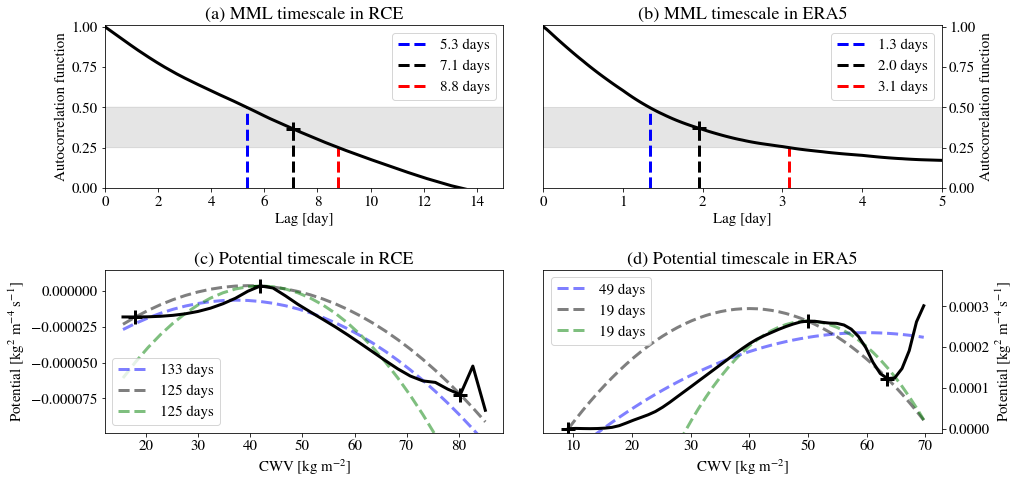

In [24]:
fig,ax = plt.subplots(2,2,figsize=(15,7.5))
plt.subplots_adjust(hspace=0.5,wspace=0.1)

# Calculate RCE quantities
tday = F2a.tcoor/(24*3600)
AC = autocorrelation_spectral(F2a.CL[240:])
tplot = tday[:AC.size]
imin = np.argmin(F2a.V[:10])
imid = np.argmax(F2a.V)
imax = np.argmin(F2a.V[:29])
ind = [imin,imid,imax]
xind = F2a.binm[ind]
yind = F2a.V[ind]
xplot = F2a.binm
yplot = F2a.V

# Panel (a)
a = ax[0][0]
a.plot(tplot,AC,color='k')
a.set_xlim((0,np.max(tplot)));
a.scatter(x=tplot[efold(AC)[0]],y=efold(AC)[1],marker='+',s=20*siz,color='k')
a.fill_between(x=tplot,y1=efold(AC,factor=0.25)[1],y2=efold(AC,factor=0.5)[1],color='k',alpha=0.1)

COL = ['b','k','r']
for iline,fac in enumerate([0.5,np.exp(-1),0.25]):
    a.vlines(x=tplot[efold(AC,factor=fac)[0]],ymin=0,ymax=efold(AC,factor=fac)[1],linestyle='--',
             color=COL[iline],label='%02.1f'%tplot[efold(AC,factor=fac)[0]]+' days')

a.set_ylim((0,1.01))
a.set_xlim((0,15))
a.legend(loc='upper right')

a.set_xlabel('Lag [day]')
a.set_ylabel('Autocorrelation function')
a.set_title('(a) MML timescale in RCE')

# Panel (c)
a = ax[1][0]
a.plot(xplot,binm_V_fit(xplot[imin:imax],yplot[imin:imax],xplot),color='b',linestyle='--',
         alpha=0.5,label='%02.0f'%binm_V_tau(xplot[imin:imax],yplot[imin:imax])+' days')
a.plot(xplot,xind_yind_fit(xind,yind,xplot),color='k',linestyle='--',
         alpha=0.5,label='%02.0f'%xind_yind_tau(xind,yind)+' days')
a.plot(xplot,loc_curv_fit(xind,yind,xplot),linestyle='--',color='g',
         alpha=0.5,label='%02.0f'%loc_curv_tau(xind,yind)+' days')
a.plot(xplot,yplot,color='k')
a.scatter(xind,yind,marker='+',s=20*siz,color='k')

a.set_ylim((-0.99e-4,0.15e-4))
a.legend(loc='lower left')
a.set_ylabel(r'Potential [kg$^{2}$ m$^{-4}$ s$^{-1}$]')
a.set_xlabel(r'CWV [kg m$^{-2}$]')
a.set_title('(c) Potential timescale in RCE')

# Calculate ERA5 quantities
AC = autocorrelation_spectral(cont_t)
tplot = np.arange(0,np.size(AC))/24
imin = np.argmin(F2b.Vfinal[:30])
imid = np.argmax(F2b.Vfinal[10:40])+10
imax = np.argmin(F2b.Vfinal[30:])+30
ind = [imin,imid,imax]
xind = F2b.binm_Vfinal[ind]
yind = F2b.Vfinal[ind]
xplot = F2b.binm_Vfinal
yplot = F2b.Vfinal

# Panel (b)
a = ax[0][1]
a.plot(tplot,AC,color='k')
a.set_xlim((0,np.max(tplot)));
a.scatter(x=tplot[efold(AC)[0]],y=efold(AC)[1],marker='+',s=20*siz,color='k')
a.fill_between(x=tplot,y1=efold(AC,factor=0.25)[1],y2=efold(AC,factor=0.5)[1],color='k',alpha=0.1)

COL = ['b','k','r']
for iline,fac in enumerate([0.5,np.exp(-1),0.25]):
    a.vlines(x=tplot[efold(AC,factor=fac)[0]],ymin=0,ymax=efold(AC,factor=fac)[1],linestyle='--',
               color=COL[iline],label='%02.1f'%tplot[efold(AC,factor=fac)[0]]+' days')

a.set_ylim((0,1.01))
a.set_xlim((0,5))
a.legend(loc='upper right')
a.yaxis.tick_right()
a.yaxis.set_label_position("right")

a.set_xlabel('Lag [day]')
a.set_ylabel('Autocorrelation function')
a.set_title('(b) MML timescale in ERA5')

# Panel (d)
a = ax[1][1]
a.plot(xplot,binm_V_fit(xplot[imin:imax],yplot[imin:imax],xplot),color='b',linestyle='--',
         alpha=0.5,label='%02.0f'%binm_V_tau(xplot[imin:imax],yplot[imin:imax])+' days')
a.plot(xplot,xind_yind_fit(xind,yind,xplot),color='k',linestyle='--',
         alpha=0.5,label='%02.0f'%xind_yind_tau(xind,yind)+' days')
a.plot(xplot,loc_curv_fit(xind,yind,xplot),linestyle='--',color='g',
         alpha=0.5,label='%02.0f'%loc_curv_tau(xind,yind)+' days')
a.plot(xplot,yplot,color='k')
a.scatter(xind,yind,marker='+',s=20*siz,color='k')

a.set_ylim((-0.1e-4,3.9e-4))
a.yaxis.tick_right()
a.yaxis.set_label_position("right")
a.legend(loc='upper left')
a.set_ylabel(r'Potential [kg$^{2}$ m$^{-4}$ s$^{-1}$]')
a.set_xlabel(r'CWV [kg m$^{-2}$]')
a.set_title('(d) Potential timescale in ERA5')

# Save figure
path_home = '/users/tbeucler/'
plt.draw()
plt.savefig('FigD1.pdf',format='pdf')